<a href="https://colab.research.google.com/github/Naina-j04/Atri-Assignment/blob/main/GarbageClassifier_with_all_layers_frozen_except_last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from PIL import Image
from collections import Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#pointing to dataset
data_dir  = '/content/drive/MyDrive/Garbage_classification/Data'

classes = os.listdir(data_dir)
print(classes)

['plastic', 'trash', 'paper', 'glass', 'metal', 'cardboard', 'garbage.pth', 'bettermodel.pth', 'bettermodel2.pth']


In [ ]:
#resizing and normalizing the dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = ImageFolder(data_dir, transform = transformations)

In [ ]:
len(dataset)


2527

In [ ]:
#splitting the dataset
train_data,val_data,test_data=random_split(dataset,[1616,405,506])
len(train_data),len(val_data),len(test_data)

(1616, 405, 506)

In [ ]:
#checking how many images from each class split b/w TVT
train_idx = train_data.indices
val_idx   = val_data.indices
test_idx  = test_data.indices

print("Train class counts:", Counter([dataset.targets[i] for i in train_idx]))
print("Val class counts:", Counter([dataset.targets[i] for i in val_idx]))
print("Test class counts:", Counter([dataset.targets[i] for i in test_idx]))


Train class counts: Counter({3: 372, 1: 338, 4: 294, 0: 275, 2: 267, 5: 70})
Val class counts: Counter({3: 95, 4: 87, 1: 83, 2: 59, 0: 51, 5: 30})
Test class counts: Counter({3: 127, 4: 101, 2: 84, 1: 80, 0: 77, 5: 37})


In [ ]:
model = models.resnet50(weights='DEFAULT')

# Freeze the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer for your 6 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 125MB/s]


In [ ]:
#dataloader
train_loader=DataLoader(train_data,batch_size=32,shuffle=True)
val_loader=DataLoader(val_data,batch_size=32,shuffle=False)
test_loader=DataLoader(test_data,batch_size=32,shuffle=False)

In [ ]:
#defining the training components
classes=6
model=models.resnet50(classes)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
device

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


device(type='cuda')

In [ ]:
num_epochs = 25
print("Starting Training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

print('Finished Training.')


Starting Training...
Epoch [1/25], Training Loss: 1.5379, Validation Loss: 1.0001, Validation Accuracy: 65.19%
Epoch [2/25], Training Loss: 0.8357, Validation Loss: 1.2859, Validation Accuracy: 64.20%
Epoch [3/25], Training Loss: 0.6953, Validation Loss: 0.7691, Validation Accuracy: 72.59%
Epoch [4/25], Training Loss: 0.5729, Validation Loss: 1.5327, Validation Accuracy: 60.99%
Epoch [5/25], Training Loss: 0.5471, Validation Loss: 0.6197, Validation Accuracy: 77.28%
Epoch [6/25], Training Loss: 0.4944, Validation Loss: 0.8610, Validation Accuracy: 73.09%
Epoch [7/25], Training Loss: 0.4838, Validation Loss: 0.5758, Validation Accuracy: 82.22%
Epoch [8/25], Training Loss: 0.3669, Validation Loss: 0.6081, Validation Accuracy: 79.26%
Epoch [9/25], Training Loss: 0.3369, Validation Loss: 0.9287, Validation Accuracy: 71.60%
Epoch [10/25], Training Loss: 0.3804, Validation Loss: 0.5984, Validation Accuracy: 81.98%
Epoch [11/25], Training Loss: 0.3089, Validation Loss: 0.5180, Validation Accu

In [ ]:
# FINAL TEST EVALUATION
print('Starting Final Evaluation on Test Set...')
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
accuracy = 100 * correct / total
print(f'Final Test Loss: {avg_test_loss:.4f}, Final Test Accuracy: {accuracy:.2f}%')

Starting Final Evaluation on Test Set...
Final Test Loss: 0.4619, Final Test Accuracy: 86.56%


In [ ]:
path='/content/drive/MyDrive/Garbage_classification/Data/model_resnet1.pth'
torch.save(model.state_dict(), path)

In [ ]:
model = models.resnet50()
path = '/content/drive/MyDrive/Garbage_classification/Data/model_resnet1.pth'
model.load_state_dict(torch.load(path))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def predict_image(image_path):
    # Preprocessing prediction images
    transformations = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    # Loading images
    image = Image.open(image_path).convert('RGB')
    image_tensor = transformations(image).unsqueeze(0).to(device)
    class_names = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]
    # Prediction time
    with torch.no_grad():
        output = model(image_tensor)
    _, predicted_idx = torch.max(output, 1)
    predicted_class = class_names[predicted_idx.item()]
    return predicted_class
# Eg multiple images
image_paths = [
    '/content/drive/MyDrive/Garbage_classification/Data/paper/paper80.jpg',
    '/content/drive/MyDrive/Garbage_classification/Data/plastic/plastic12.jpg',
    '/content/drive/MyDrive/Garbage_classification/Data/glass/glass99.jpg',
    '/content/drive/MyDrive/Garbage_classification/Data/cardboard/cardboard167.jpg',
    '/content/drive/MyDrive/Garbage_classification/Data/metal/metal77.jpg',
    '/content/drive/MyDrive/Garbage_classification/Data/trash/trash109.jpg',
    '/content/drive/MyDrive/Garbage_classification/Data/trash/trash105.jpg'
]

for img_path in image_paths:
    result = predict_image(img_path)
    print(f"The model predicts the image is: {result}")


The model predicts the image is: paper
The model predicts the image is: plastic
The model predicts the image is: glass
The model predicts the image is: glass
The model predicts the image is: metal
The model predicts the image is: trash
The model predicts the image is: trash


In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


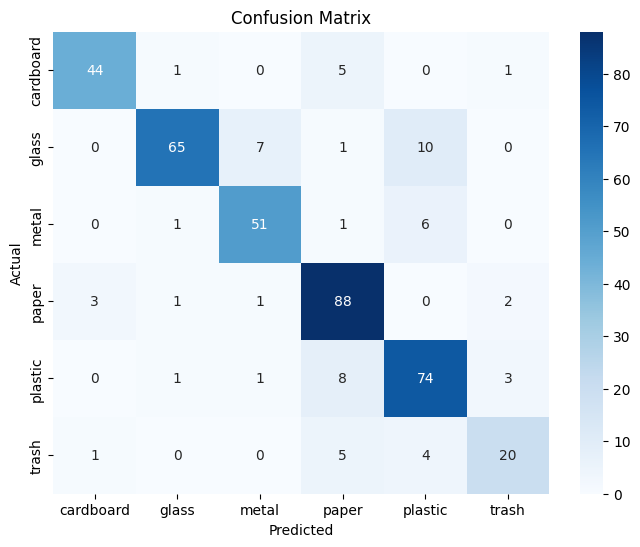

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
class_names = dataset.classes  # ['cardboard','glass','metal','paper','plastic','trash']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
